<center><h1>Self-Organizing Map (SOM)</h1></center>

## Summary:
1. [Introduction](#introduction)

2. [SOM CPU implementation](#som_cpu)
    
3. [SOM GPU implementation](#som_gpu)

4. [Performance comparison](#performance_comparison)

# 1. Introduction <a class="anchor" id="introduction"></a>

Self-Organizing Map (SOM) is a competitive neural network introduced by Teuvo Kohonen (Kohonen, 1997). SOM neural networks can be used in both clustering and Vector Quantization (VQ) tasks, and they use only the input data attributes for organizing clusters based on the similarity between samples. The main objective of the SOM network consists of mapping a continuous high-dimensional space to a discrete space with reduced size. This mapping, or projection, is composed by $N_w$ neurons (or prototypes) organized in a $S$-dimensional space, typically two-dimensional. Formally, for a continuous space $\mathcal{X} \subset \mathbb{R}^D$ and a discrete space $\mathcal{Y} \subset \mathbb{R}^S$, composed by $N_w$ prototypes, a vector $\vec{x} \in \mathcal{X}$ will be represented by the network for a vector $y_{i^*} \in \mathcal{Y}$ by the mapping $i^*(x): \mathcal{X} \to \mathcal{Y}$. For training a SOM network, firstly the $N_w$ neurons' weights are randomly initialized. After proper initialization, the algorithm proceeds with two essential stages (Haykin et al., 2009):


1. **Competition**: For a input pattern $\vec{x}(n)$, the SOM network calculates the nearest prototype (winner) to $\vec{x}(n)$, based on a similarity measure:

    $$ i^*(n) = arg \ min ||\vec{x}(n) - \vec{w}_i(n)||, \forall i $$

    where $||\cdot||$ denotes the Euclidean Distance.
    
    
2. **Cooperation**: The winner prototype's weights, as well as its neighbours' weights, are adjusted based on the following learning rule:

    $$ \vec{w}_i (n + 1) = \vec{w}_i (n) + \alpha(n) h_{i,{i^*}(n)}(n) [\vec{x}(n) - \vec{w}_i(n)] $$
    
    where $0 < \alpha(n) < 1$, correspond to the learning rate in iteration $n$. The funciton $h_{i,{i^*}(n)}$ is referred as neighbouring function. This function defines a neighbourhood around the winning prototype. Therefore, the prototypes that will be adjusted is the winning prototype and its neighbours. A typically used topological neighborhood is the *Gaussian* function:
    
    $$ h_{i,{i^*}(n)}(n) = \exp{ \left [ -\frac{ {||\vec{r}_i - \vec{r}_{i^*(n)} ||}^2}{2\sigma^2(n)} \right ]} $$
    
    where $\vec{r}_i$ and $\vec{r}_{i^*(n)}$ are, respectively, the coordinates of the $i$-th neuron and the winner neuron $i^*(n)$. The parameter $\sigma(n) >  0$ refers to the neighborhood width considered. The larger the neighborhood the higher the number of neurons updated around the winning neuron. To ensure the convergence of the SOM network weights to stable values during the training algorithm, it is necessary to reduce the parameter of neighboring and the learning step. Considering $\sigma_0$ and $\alpha_0$ their initial values. The neighborhood's size $\sigma$ and the learning rate $\alpha$ can be reduced over time, by an exponential decay:
    
    $$ \sigma(n) = \sigma_0 \exp{ \left ( - \frac{n}{\tau_1} \right )} $$
    
    $$ \alpha(n) = \alpha_0 \exp{ \left ( - \frac{n}{\tau_2} \right )} $$
    
    where  $\tau_1$ and $\tau_2$ are time constants to be defined by the designer.

In [1]:
%run -i 'load_dataset.py' # loading dataset

Dataset:  Features.shape:   # of classes:
vc2c      (310, 6)          2
vc3c      (310, 6)          3
wf24f     (5456, 24)        4
wf4f      (5456, 4)         4
wf2f      (5456, 2)         4
pk        (195, 22)         2


# 2. SOM CPU implementation <a class="anchor" id="som_cpu"></a>

In [174]:
%%timeit X=np.random.rand(5000,10); neurons=np.random.rand(400,10)
SSD = 0
for x in X: # can it be vectorized?
    dist_2 = np.sum((neurons - x)**2, axis=1) # norm**2
    SSD += np.amin(dist_2)

126 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [175]:
%%timeit X=np.random.rand(5000,10); neurons=np.random.rand(400,10)
distances = cdist(X, neurons)
SSD = np.sum(
    np.amin(distances, axis=1)**2
)    

15.2 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [176]:
import numpy as np
import plotly.offline as plt
import plotly.graph_objs as go
from random import randint
import ipywidgets as widgets
from IPython.display import clear_output
from plotly import tools
from math import ceil
from scipy.spatial.distance import cdist

plt.init_notebook_mode(connected=True) # enabling plotly inside jupyter notebook

class SOM:
    'Class of Self Organizing Maps conected in a two-dimensional grid.'
    
    def __init__(self, nRows, nColumns): 
        self.nRows    = nRows
        self.nColumns = nColumns
        self.__epochs = 0 # number of epochs of trained SOM
        
        self.neurons = None
        self.indexes = None # list of index2D <=> index1D
        
        self.neuronsHist = None
        self.ssdHist     = None
        
    def init(self, X): # giving the data, so we can define maximum and minimum in each dimension
        # reset neuronsHist and ssdHist
        self.neuronsHist = None 
        self.ssdHist     = None
        
        dim = X.shape[1] # number of features
        rand = np.random.rand(self.nRows*self.nColumns, dim) # Auxiliary random element
        # find min-max for each dimension
        minimum = np.amin(X, axis=0)
        maximum = np.amax(X, axis=0)
        # Initializing neurons in random positions between minimum and maximum of the dataset
        self.neurons = (maximum - minimum)*rand + minimum
        
        # list of index2D == index1D
        self.indexes = self.index1Dto2D(np.arange(len(self.neurons))) 
        
    
    def fit(self, X, alpha0, sigma0, nEpochs=100, saveNeuronsHist=False, saveSSDHist=True, tol=1e-6,
              verboses=0, batchSize=np.inf):
        if self.neurons is None: self.init(X) # if self.init() wasn't run
        
        tau1 = nEpochs/sigma0
        tau2 = nEpochs
        SSD_new = self.SSD(X) # initial SSD, from random parameters
        
        if saveNeuronsHist: 
            self.neuronsHist    = [np.zeros(self.neurons.shape)]*(nEpochs+1)
            self.neuronsHist[0] = np.copy(self.neurons) # random neurons
        if saveSSDHist:
            self.ssdHist    = np.zeros((nEpochs+1))
            self.ssdHist[0] = SSD_new # initial SSD, from random parameters
        
        sigma = sigma0
        alpha = alpha0
        inertia = np.inf # initial value of inertia
        batchSize = min(len(X), batchSize) # adjusting ill defined batchSize
        for epoch in range(nEpochs):
            # Updating alpha and sigma
            sigma = sigma0*np.exp(-epoch/tau1);
            alpha = alpha0*np.exp(-epoch/tau2);
            
            order = np.random.permutation(len(X)) # shuffling order
            for i in order[:batchSize]: # for each datapoint in the shuflled order until batchSize
                # search for winner neuron
                winner_idx = self.get_winner(X[i])
                # neighbor function
                h_ik = self.h_neighbor(winner_idx, self.indexes, sigma)
                # updating neurons
                self.neurons += (h_ik[:, np.newaxis]*(X[i] - self.neurons))*alpha
                
            
            self.__epochs+=1 # updating number of epochs trained
            if verboses==1: print("End of epoch {}".format(epoch+1))
            
            SSD_old = SSD_new
            SSD_new = self.SSD(X)
            inertia = abs((SSD_old - SSD_new)/SSD_old)
            
            # Saving if necessary
            if saveNeuronsHist: self.neuronsHist[epoch+1] = np.copy(self.neurons)
            if saveSSDHist:     self.ssdHist[epoch+1]     = SSD_new
                       
            # breaking if tolerance reached before nEpochs
            if inertia < tol:
                # history cutting
                if saveNeuronsHist: self.neuronsHist = self.neuronsHist[0:epoch+2]
                if saveSSDHist:     self.ssdHist     = self.ssdHist[0:epoch+2]
                break
            
            
    def SSD(self, X):
        distances = cdist(X, self.neurons)
        SSD = np.sum(
            np.amin(distances, axis=1)**2
        )    
        return SSD
        
    def index1Dto2D(self, index): # convert index of neurons parameter matrix to the 2D grid index
        return np.asarray([np.ceil((index+1)/self.nRows)-1, index%self.nRows], dtype='int').T
    
    def get_winner(self, x, dim=2, dist_matrix=False):
        dist_2 = np.sum((self.neurons - x)**2, axis=1) # norm**2
        
        temp = np.argmin(dist_2)
        winner = self.index1Dto2D(temp) if dim==2 else temp
        
        result = winner if dist_matrix==False else (winner, dist_2)
        return result
        
    def h_neighbor(self, idx_1, idx_2, sigma):
        dist_2 = np.sum((idx_2 - idx_1)**2, axis=1) # norm**2
        return np.exp( -dist_2/(2*sigma**2) )
    
    def getLabels(self, X, dim=1): # get labels in 1 dimension or 2 dimension (neuron grid)
        N = len(X)
        labels = np.zeros((N,dim), dtype='int')
        for i in range(N):
            labels[i,:] = self.get_winner(X[i,:],dim)
        return labels
    
    def plotSSD(self):
        traceData = go.Scatter(
            x = [i+1 for i in range(self.__epochs)], # epochs
            y = self.ssdHist, 
            mode='lines',
            name='SSD')
        data = [traceData]
        layoutData = go.Layout(
            title = "SSD history",
            xaxis=dict(title='Epoch'),
            yaxis=dict(title='SSD')
        )

        fig = go.Figure(data=data, layout=layoutData)
        plt.iplot(fig)
    
        
    def plotSOM(self, X=None):
        if self.neuronsHist is not None:
            # Int box to change the iteration number
            n_txt = widgets.BoundedIntText(
                value=0,
                min=0,
                max=len(self.neuronsHist)-1,
                step=10,
                description='epoch:'
            )    
        ###############################################################
        # Function to draw the graph
        def upgradeChart(change):
            clear_output()
            if self.neuronsHist is not None:
                display(n_txt)    
                n_ = change['new'] # new iteration number

            if self.neuronsHist is not None:
                x = self.neuronsHist[n_][:,0].tolist() 
                y = self.neuronsHist[n_][:,1].tolist()
                name = 'neurons [epoch ='+str(n_)+']'
            else:
                x = self.neurons[:,0].tolist()
                y = self.neurons[:,1].tolist()
                name = 'neurons'

            neurons = go.Scatter(x=x, y=y, mode='markers', name=name, 
                                 marker = dict(size=10,color = '#673AB7'))

            # cada linha que conecta os neurônios
            linhas = [{}]*(2*self.nRows*self.nColumns - self.nRows - self.nColumns)
            count=0 #contador para saber qual linha estamos
            for linha in range(self.nRows): # conecta da esquerda para direita
                for coluna in range(self.nColumns): # e de cima para baixo
                    try:
                        if self.neuronsHist is not None:
                            x0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna+1)).all(axis=1))[0][0], 0]
                            y1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna+1)).all(axis=1))[0][0], 1]
                        else:
                            x0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neurons[np.where((self.indexes==(linha,coluna+1)).all(axis=1))[0][0], 0]
                            y1 = self.neurons[np.where((self.indexes==(linha,coluna+1)).all(axis=1))[0][0], 1]

                        linhas[count]= {'type':'line','x0':x0,'y0': y0,'x1':x1,'y1':y1,
                                        'line': {'color': '#673AB7','width': 1,}}
                        count+=1
                    except: # edge of the grid
                        pass
                    try:
                        if self.neuronsHist is not None:
                            x0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha+1, coluna)).all(axis=1))[0][0], 0]
                            y1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha+1, coluna)).all(axis=1))[0][0], 1]
                        else:
                            x0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neurons[np.where((self.indexes==(linha+1,coluna)).all(axis=1))[0][0], 0]
                            y1 = self.neurons[np.where((self.indexes==(linha+1,coluna)).all(axis=1))[0][0], 1]

                        linhas[count] = {'type': 'line','x0': x0,'y0': y0,'x1': x1,'y1': y1,
                                         'line': {'color': '#673AB7','width': 1}}
                        count+=1
                    except: # edge of the grid
                        pass

            data = []
            title = ""
            if X is not None:
                datapoints = go.Scatter(x = X[:,0], y = X[:,1], mode='markers', name='data',
                                        marker = dict(size = 5,color = '#03A9F4'))
                data = [datapoints, neurons]
                title = "Data + SOM"
            else:
                data = [neurons]
                title = "SOM"

            layout = go.Layout(title=title, xaxis=dict(title="$x_1$"), yaxis=dict(title="$x_2$"),
                               shapes=linhas)

            fig = go.Figure(data=data, layout=layout)
            plt.iplot(fig)
        ###########################################################################

        if self.neuronsHist is not None: n_txt.observe(upgradeChart, names='value')
        upgradeChart({'new': 0})

In [177]:
# Function to scale data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Função para mudar a escala dos dados
def scale_feat(X_train, X_test, scaleType='min-max'):
    if scaleType=='min-max' or scaleType=='std':
        X_tr_norm = np.copy(X_train) # fazendo cópia para deixar original disponível
        X_ts_norm = np.copy(X_test)
        scaler = MinMaxScaler(copy=False) if scaleType=='min-max' else StandardScaler(copy=False)
        scaler.fit(X_tr_norm)
        X_tr_norm = scaler.transform(X_tr_norm)
        X_ts_norm = scaler.transform(X_ts_norm)
        return (X_tr_norm, X_ts_norm)
    else:
        raise ValueError("Tipo de escala não definida. Use 'min-max' ou 'std'.")

Example of `SOM` class running:

In [178]:
%%time
import datetime
print(datetime.datetime.now())

nEpochs = 30
print("nEpochs = {}".format(nEpochs))

data = datasets['wf2f']
N = len(data['features'].index) # number of datapoints
l = ceil((5*N**.5)**.5) # tamanho do lado da grid quadrada de neurônios
X = data['features'].values.copy()

X1, X2 = scale_feat(X,X,scaleType='min-max')
X=X1

som = SOM(l, l)
som.fit(X=X, alpha0=0.1, sigma0=3, nEpochs=nEpochs, saveNeuronsHist=False, verboses=1)
print(som.ssdHist[-1])

2019-08-01 17:14:01.242263
nEpochs = 30
End of epoch 1
End of epoch 2
End of epoch 3
End of epoch 4
End of epoch 5
End of epoch 6
End of epoch 7
End of epoch 8
End of epoch 9
End of epoch 10
End of epoch 11
End of epoch 12
End of epoch 13
End of epoch 14
End of epoch 15
End of epoch 16
End of epoch 17
End of epoch 18
End of epoch 19
End of epoch 20
End of epoch 21
End of epoch 22
End of epoch 23
End of epoch 24
End of epoch 25
End of epoch 26
End of epoch 27
End of epoch 28
End of epoch 29
End of epoch 30
0.11702603612809961
CPU times: user 12.6 s, sys: 23.1 ms, total: 12.7 s
Wall time: 12.6 s


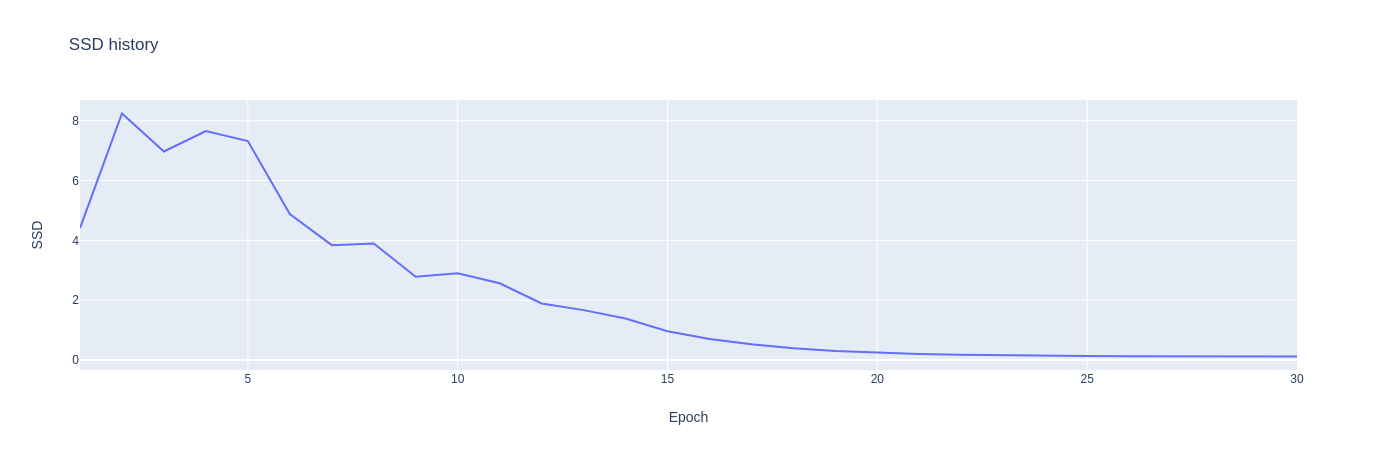

In [179]:
som.plotSSD()

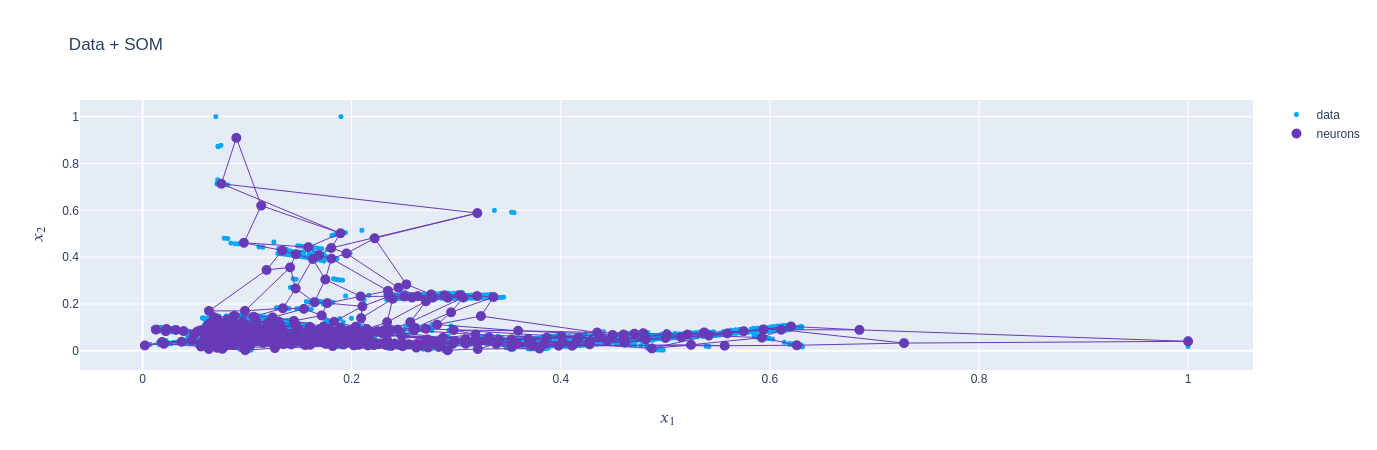

In [180]:
som.plotSOM(X)

The code below trains the SOM's in all datasets:

Note: The number of neurons chosen was approximately $5\sqrt{N}$ of the dataset and a square grid to arrange them.

In [181]:
%%time

nEpochs = 100
soms = {}
for name, data in datasets.items():
    N = len(data['features'].index) # number of datapoints
    l = ceil((5*N**.5)**.5) # side length of square grid of neurons
    X = data['features'].values
    
    # scaling dataset
    X1, X2 = scale_feat(X,X,scaleType='min-max')
    X=X1
    
    # SOM training
    som = SOM(l,l)
    som.fit(X=X, alpha0=0.1, sigma0=3, nEpochs=nEpochs)
    
    soms[name] = som
    
    print("{} done!".format(name))
    
# CPU times: user 3min 10s, sys: 114 ms, total: 3min 10s
# Wall time: 3min 10s

vc2c done!
vc3c done!
wf24f done!
wf4f done!
wf2f done!
pk done!
CPU times: user 2min 31s, sys: 0 ns, total: 2min 31s
Wall time: 2min 31s


vc2c


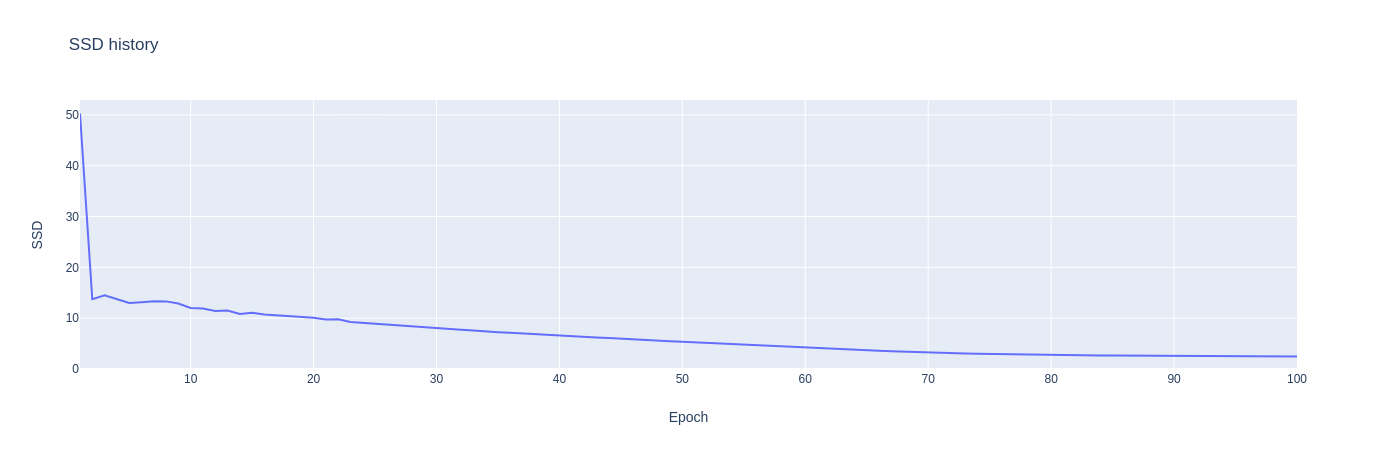

vc3c


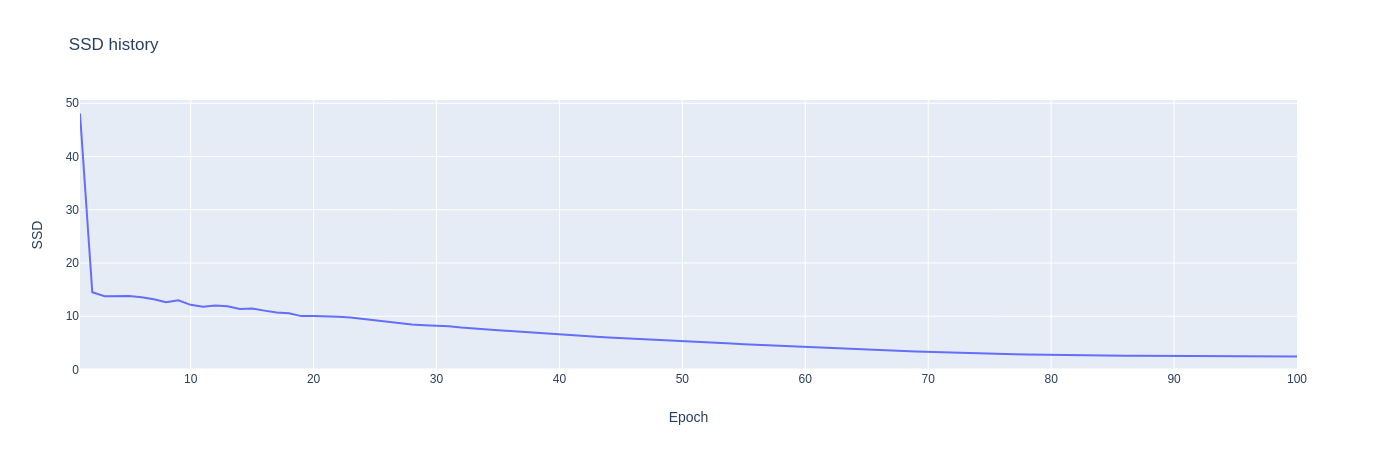

wf24f


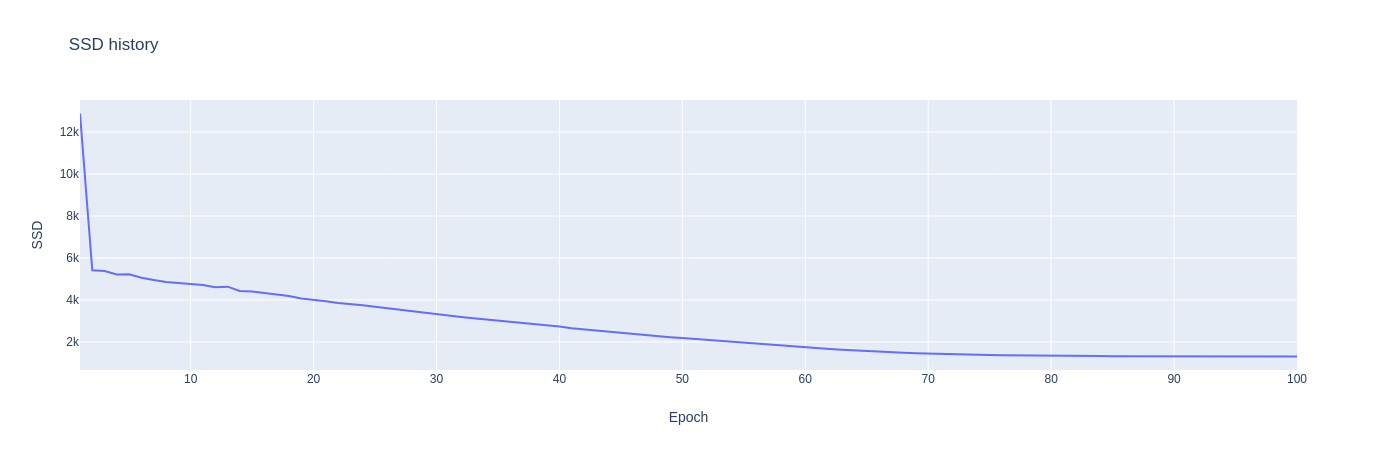

wf4f


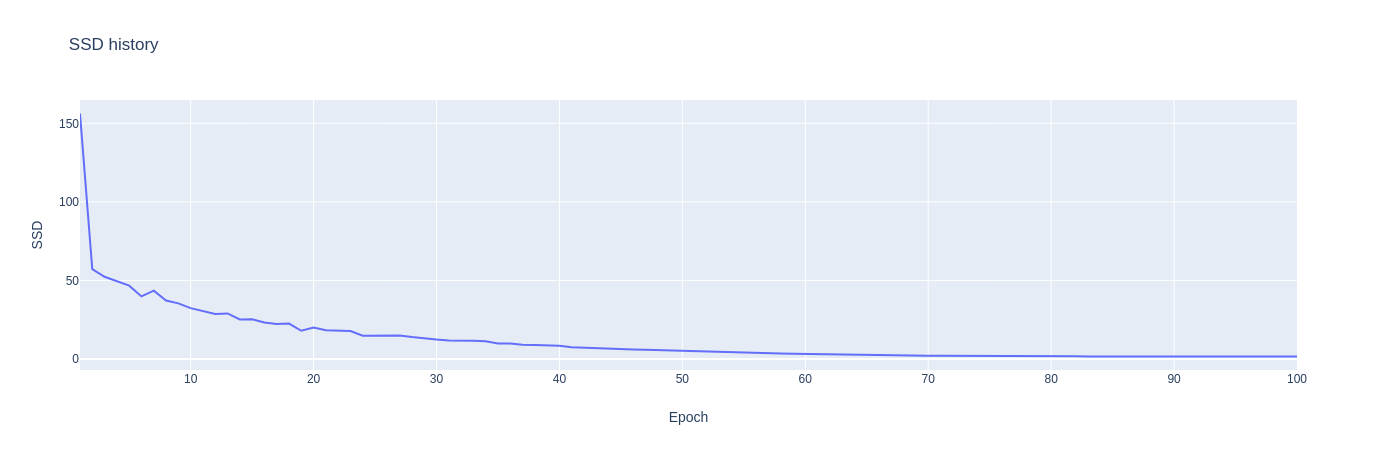

wf2f


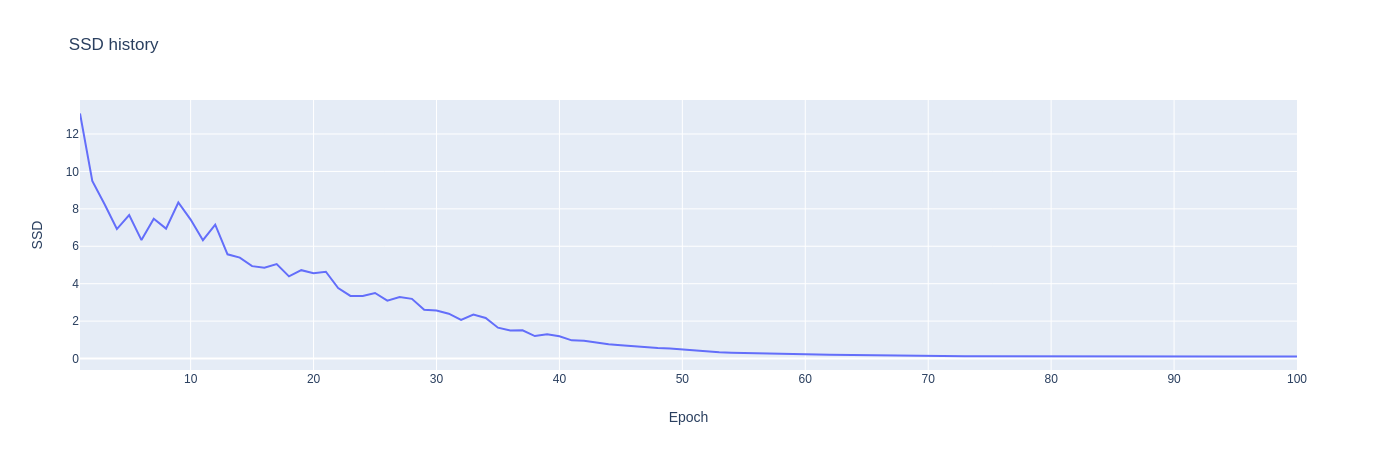

pk


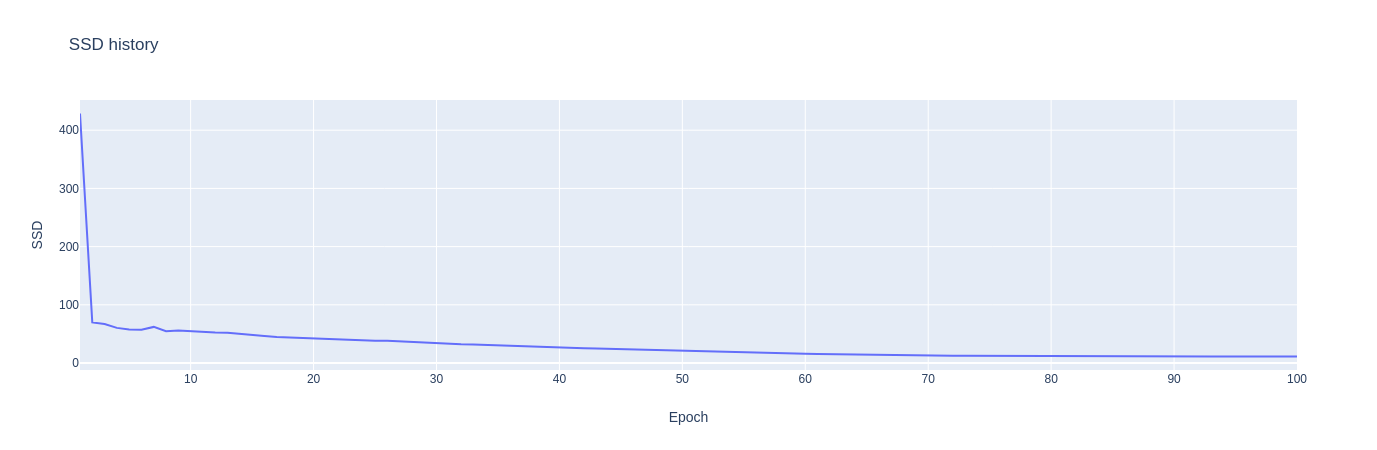

In [182]:
for dataset in datasets:
    print(dataset)
    soms[dataset].plotSSD()

# 3. SOM GPU implementation <a class="anchor" id="som_gpu"></a>

In this implementation we use `PyTorch`.

In [198]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
a+=1
print(a); print(b)

b = b.numpy()
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
[2. 2. 2. 2. 2.]


In [201]:
x = torch.ones(5)
if torch.cuda.is_available():
    device = torch.device('cuda')
    y = torch.ones_like(x, device=device)
    x = x.to(device)
    z = x + y
    
    print(z)
    print(z.to('cpu', torch.double))
    

tensor([2., 2., 2., 2., 2.], device='cuda:0')
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


In [190]:
import torch
import numpy as np
import plotly.offline as plt
import plotly.graph_objs as go
from random import randint
import ipywidgets as widgets
from IPython.display import clear_output
from plotly import tools
from math import ceil

plt.init_notebook_mode(connected=True) # enabling plotly inside jupyter notebook

class SOM_GPU:
    'Class of Self Organizing Maps conected in a two-dimensional grid. Uses GPU if possible'
    
    def __init__(self, nRows, nColumns):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.nRows    = nRows
        self.nColumns = nColumns
        self.indexes  = None # list of index2D <=> index1D
        self.neurons  = None
        
        self.__epochs    = 0 # number of epochs of trained SOM
        self.neuronsHist = None
        self.ssdHist     = None
        
    def init(self, X): # giving the data, so we can define maximum and minimum in each dimension
        device = self.device # to reduce verbosity
        X = torch.from_numpy(X).to(device)
        
        # reset neuronsHist and ssdHist
        self.neuronsHist = None 
        self.ssdHist     = None
                
        rand = torch.rand(self.nRows*self.nColumns, X.size()[1], dtype=X.dtype, device=device) # Auxiliary random element
        
        # find min-max for each feature
        minimum = torch.min(X,0)[0]
        maximum = torch.max(X,0)[0]
        
        # Initializing neurons in random positions between minimum and maximum of the dataset
        self.neurons = (maximum - minimum)*rand + minimum
                
        # list of index2D == index1D
        self.indexes = self.index1Dto2D(np.arange(len(self.neurons)))  # GPU??????
        
        return X
        
    
    def fit(self, X, alpha0, sigma0, nEpochs=100, saveNeuronsHist=False, saveSSDHist=True, tol=1e-6,
              verboses=0, batchSize=np.inf):
        if self.neurons is None: X = self.init(X) # if self.init() wasn't run
        
        tau1 = nEpochs/sigma0
        tau2 = nEpochs
        SSD_new = self.SSD(X) # initial SSD, from random parameters
        
        if saveNeuronsHist: 
            self.neuronsHist    = [np.zeros(self.neurons.shape)]*(nEpochs+1)
            self.neuronsHist[0] = np.copy(self.neurons) # random neurons
        if saveSSDHist:
            self.ssdHist    = np.zeros((nEpochs+1))
            self.ssdHist[0] = SSD_new # initial SSD, from random parameters
        
        sigma = sigma0
        alpha = alpha0
        inertia = np.inf # initial value of inertia
        batchSize = min(len(X), batchSize) # adjusting ill defined batchSize
        for epoch in range(nEpochs):
            # Updating alpha and sigma
            sigma = sigma0*np.exp(-epoch/tau1);
            alpha = alpha0*np.exp(-epoch/tau2);
            
            order = np.random.permutation(len(X)) # shuffling order
            for i in order[:batchSize]: # for each datapoint in the shuflled order until batchSize
                # search for winner neuron
                winner_idx = self.get_winner(X[i])
                # neighbor function
                h_ik = self.h_neighbor(winner_idx, self.indexes, sigma)
                # updating neurons
                self.neurons += (h_ik[:, np.newaxis]*(X[i] - self.neurons))*alpha
                
            
            self.__epochs+=1 # updating number of epochs trained
            if verboses==1: print("End of epoch {}".format(epoch+1))
            
            SSD_old = SSD_new
            SSD_new = self.SSD(X)
            inertia = abs((SSD_old - SSD_new)/SSD_old)
            
            # Saving if necessary
            if saveNeuronsHist: self.neuronsHist[epoch+1] = np.copy(self.neurons)
            if saveSSDHist:     self.ssdHist[epoch+1]     = SSD_new
                       
            # breaking if tolerance reached before nEpochs
            if inertia < tol:
                # history cutting
                if saveNeuronsHist: self.neuronsHist = self.neuronsHist[0:epoch+2]
                if saveSSDHist:     self.ssdHist     = self.ssdHist[0:epoch+2]
                break
            
            
    def SSD(self, X):
        distances = torch.cdist(X, self.neurons) # search scipy cdist for details
        SSD = torch.sum(
            torch.min(distances,1)[0]**2
        )
        return SSD
        
    def index1Dto2D(self, index): # convert index of neurons parameter matrix to the 2D grid index
        return np.asarray([np.ceil((index+1)/self.nRows)-1, index%self.nRows], dtype='int').T
    
    def get_winner(self, x, dim=2, dist_matrix=False):
        dist_2 = np.sum((self.neurons - x)**2, axis=1) # norm**2
        
        temp = np.argmin(dist_2)
        winner = self.index1Dto2D(temp) if dim==2 else temp
        
        result = winner if dist_matrix==False else (winner, dist_2)
        return result
        
    def h_neighbor(self, idx_1, idx_2, sigma):
        dist_2 = np.sum((idx_2 - idx_1)**2, axis=1) # norm**2
        return np.exp( -dist_2/(2*sigma**2) )
    
    def getLabels(self, X, dim=1): # get labels in 1 dimension or 2 dimension (neuron grid)
        N = len(X)
        labels = np.zeros((N,dim), dtype='int')
        for i in range(N):
            labels[i,:] = self.get_winner(X[i,:],dim)
        return labels
    
    def plotSSD(self):
        traceData = go.Scatter(
            x = [i+1 for i in range(self.__epochs)], # epochs
            y = self.ssdHist, 
            mode='lines',
            name='SSD')
        data = [traceData]
        layoutData = go.Layout(
            title = "SSD history",
            xaxis=dict(title='Epoch'),
            yaxis=dict(title='SSD')
        )

        fig = go.Figure(data=data, layout=layoutData)
        plt.iplot(fig)
    
        
    def plotSOM(self, X=None):
        if self.neuronsHist is not None:
            # Int box to change the iteration number
            n_txt = widgets.BoundedIntText(
                value=0,
                min=0,
                max=len(self.neuronsHist)-1,
                step=10,
                description='epoch:'
            )    
        ###############################################################
        # Function to draw the graph
        def upgradeChart(change):
            clear_output()
            if self.neuronsHist is not None:
                display(n_txt)    
                n_ = change['new'] # new iteration number

            if self.neuronsHist is not None:
                x = self.neuronsHist[n_][:,0].tolist() 
                y = self.neuronsHist[n_][:,1].tolist()
                name = 'neurons [epoch ='+str(n_)+']'
            else:
                x = self.neurons[:,0].tolist()
                y = self.neurons[:,1].tolist()
                name = 'neurons'

            neurons = go.Scatter(x=x, y=y, mode='markers', name=name, 
                                 marker = dict(size=10,color = '#673AB7'))

            # cada linha que conecta os neurônios
            linhas = [{}]*(2*self.nRows*self.nColumns - self.nRows - self.nColumns)
            count=0 #contador para saber qual linha estamos
            for linha in range(self.nRows): # conecta da esquerda para direita
                for coluna in range(self.nColumns): # e de cima para baixo
                    try:
                        if self.neuronsHist is not None:
                            x0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna+1)).all(axis=1))[0][0], 0]
                            y1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna+1)).all(axis=1))[0][0], 1]
                        else:
                            x0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neurons[np.where((self.indexes==(linha,coluna+1)).all(axis=1))[0][0], 0]
                            y1 = self.neurons[np.where((self.indexes==(linha,coluna+1)).all(axis=1))[0][0], 1]

                        linhas[count]= {'type':'line','x0':x0,'y0': y0,'x1':x1,'y1':y1,
                                        'line': {'color': '#673AB7','width': 1,}}
                        count+=1
                    except: # edge of the grid
                        pass
                    try:
                        if self.neuronsHist is not None:
                            x0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha, coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha+1, coluna)).all(axis=1))[0][0], 0]
                            y1 = self.neuronsHist[n_][np.where(
                                (self.indexes==(linha+1, coluna)).all(axis=1))[0][0], 1]
                        else:
                            x0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   0]
                            y0 = self.neurons[np.where((self.indexes==(linha,coluna)).all(axis=1))[0][0],   1]
                            x1 = self.neurons[np.where((self.indexes==(linha+1,coluna)).all(axis=1))[0][0], 0]
                            y1 = self.neurons[np.where((self.indexes==(linha+1,coluna)).all(axis=1))[0][0], 1]

                        linhas[count] = {'type': 'line','x0': x0,'y0': y0,'x1': x1,'y1': y1,
                                         'line': {'color': '#673AB7','width': 1}}
                        count+=1
                    except: # edge of the grid
                        pass

            data = []
            title = ""
            if X is not None:
                datapoints = go.Scatter(x = X[:,0], y = X[:,1], mode='markers', name='data',
                                        marker = dict(size = 5,color = '#03A9F4'))
                data = [datapoints, neurons]
                title = "Data + SOM"
            else:
                data = [neurons]
                title = "SOM"

            layout = go.Layout(title=title, xaxis=dict(title="$x_1$"), yaxis=dict(title="$x_2$"),
                               shapes=linhas)

            fig = go.Figure(data=data, layout=layout)
            plt.iplot(fig)
        ###########################################################################

        if self.neuronsHist is not None: n_txt.observe(upgradeChart, names='value')
        upgradeChart({'new': 0})

In [191]:
%%time
import datetime
print(datetime.datetime.now())

nEpochs = 5
print("nEpochs = {}".format(nEpochs))

data = datasets['wf2f']
N = len(data['features'].index) # number of datapoints
l = ceil((5*N**.5)**.5) # tamanho do lado da grid quadrada de neurônios
X = data['features'].values.copy()

X1, X2 = scale_feat(X,X,scaleType='min-max')
X=X1

som = SOM_GPU(l, l)
som.fit(X=X, alpha0=0.1, sigma0=3, nEpochs=nEpochs, saveNeuronsHist=True, verboses=1)
print(som.ssdHist[-1])

2019-08-01 17:22:10.544919
nEpochs = 5


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

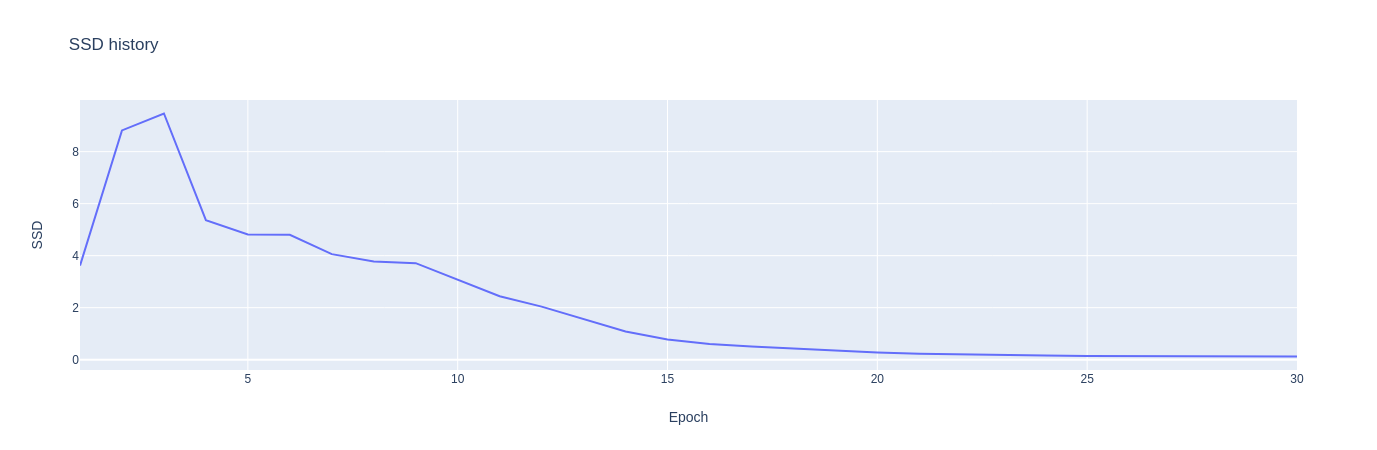

In [11]:
som.plotSSD()

In [ ]:
som.plotSOM(X)

# 4. Performance comparison <a class="anchor" id="performance_comparison"></a>